
# Theory of velocity interpolation for a single point time series
<br>
<br>

#### **Problem:**

*Find a smooth regularly spaced timeseries of velocities given a set of average measurements of possibly overlapping and variable length time intervals*

<br>
<br>

#### **Start: we formulate it as an inverse problem**

*Find a velocity vector $\mathbf{v}$ that minimizes the following functional:*

<br>

$U(\mathbf{v},\lambda) = \|\mathbf{vInv}\|_r + \lambda \|A_{m}\mathbf{vInv} - \mathbf{vObs}\|$

<br>

- $\mathbf{vObs}$: velocity measurements

- $\mathbf{vInv}$: vector of speeds that we are solving for at a regular interval (for example daily)

- $\|.\|_r$: is a roughness norm (measure of the first or second derivative)

- $\lambda$: can be seen as a Lagrange multiplier (it enforces the condition in the expression behind it), or one can think of it as a relative weight of how well we want it to fit the data versus how smooth the resulting interpolated velocity should be.

- $\mathbf{A_{m}}$: indexing matrix that specifies over which time interval a velocity was measured (and averages it appropriately).

<br>

#### **The inversion in words**

In our equation, $\lambda$ can take several forms. In order to find a good solution, because we have prior knowledge on the ice, we can assume specific **regularization** terms: coefficients that will guide the solution towards its final shape.

For example: if we look at a glacier's velocities, we can assume that the velocities close in time to each other are likely to have similar values. Same thing in space. The further away you go in space & time from your point, the less the values of these distant points will be representative of the point you're trying to invert. 

*In short: we "punish" values far in space and time so they "weight" less in the solution.*

Mathematically, a strong regularization factor (or coefficient) in space will smoothen the output of the inversion, thus avoiding spikes in the solution. This could be very adapted for a non-surging glacier, but could completely erase a surge from a dataset. Which is why **knowing your dataset is important**.


<br>


#### **Design Matrix part 1: Date Span Matrix**

For a simple example, assume you want daily velocities for 6 days, and you have a measurement of the average velocity from day 1 to day 4 ($d_1$) and from day 3 to day 5 ($d_2$). We then have:

$$A_{m} = \begin{bmatrix}
		1/4 & 1/4 & 1/4 & 1/4 & 0 & 0 \\ 
		0 & 0 & 1/3 & 1/3 & 1/3 & 0
		\end{bmatrix}$$

<br>

**Dimensions:** The number of rows is equal to the number of measurements $N$ (same dimension as $\mathbf{vObs}$) and the number of columns $M$ (same dimension as $\mathbf{vInv}$).

<br>

#### **Design Matrix part 2: Temporal Regularization Matrix**

In order to regularize the matrix in time, we create a matrix of regularization $\mathbf{reg_{time}}$ which dimensions are $(M-D)$ x $M$ (D is the degree of the derivative used for the regularization), for which each entry will be depending on the $\lambda$ term and the order of the term we apply the regularization to (approximation of finite differences). The variable *h* is the set time-interval between each timestamp.

**1st derivative regularization:** $f'(x) \approx \frac{f_{i+1} - f_{i}}{h}$  Matrix size: $(M-1)$ x $M$ 

Which would result in: $$reg_{time} = \begin{bmatrix}
										-\frac{\lambda}{h} & \frac{\lambda}{h} &  &  &  & 0 \\ 
										 & -\frac{\lambda}{h} & \frac{\lambda}{h}&  &  &  \\
										 &  & \frac{\lambda}{h} & \frac{\lambda}{h}&  &  \\
										 &  &  & -\frac{\lambda}{h} & \frac{\lambda}{h}&  \\
										 0 &  &  &  & -\frac{\lambda}{h} & \frac{\lambda}{h} \\
										\end{bmatrix}$$

<br>

**2nd derivative regularization:** $f''(x) \approx \frac{f_{i+2} - 2f_{i+1} + f_{i}}{h}$  Matrix size: $(M-2)$ x $M$ 

Which would result in: $$reg_{time} = \begin{bmatrix}
										\frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  & 0 \\ 
										 & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  \\
										 &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  \\
										 0 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} \\
										\end{bmatrix}$$

<br>

#### **Design Matrix part 3: Assemble the Design Matrix**
And we finally obtain our main design matrix (with 2nd derivative), which is a concatenation of $A_{m}$ and $reg_{mat}$:

$$A_{des} = \begin{bmatrix}				\\ & & A_{m} & & & \\ \\
										\frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  & 0 \\ 
										 & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  \\
										 &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  \\
										 0 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} \\
										\end{bmatrix}$$

<br>

#### **Extend the vector of observations**

Because we added a regularization matrix to our design matrix, we need to extend our vector of observations $\mathbf{vObs}$ so we can calculate the inversion:

$$\begin{bmatrix} v_{0} \\ v_{1} \\ ... \\ v_{n} \end{bmatrix} to \begin{bmatrix} v_{0} \\ v_{1} \\ ... \\ v_{n} \\ 0 \\ 0 \\ ... \\ 0 \end{bmatrix} $$



With the amount of 0s appended being $(M-1)$

The obtained velocity vector is then the size of the regular matrix in time. 
(We can add a spatial regularization but it increases the computation time by 3.)

<br>

#### **Final Part: Solve the Linear System of Equations**

$A_{reg}^{T}A_{reg}\mathbf{vInv}= A_{reg}^{T}\mathbf{vObs}$

<br>

Using a linear solver (`np.linalg.solve()`, `scipy.linalg.solve()`, `torch.linalg.solve()`) find $\mathbf{vInv}$ satisfying the equation, which is equivalent to solving: $U(\mathbf{v},\lambda) = \|\mathbf{vInv}\|_r + \lambda \|A_{m}\mathbf{vInv} - \mathbf{vObs}\|$. 

We can use a linear solver because the matrix $A_{reg}^{T}A_{reg}$ is square, symmetrical positive.

<br>
<br>


# Inversion with Regularization Matrix
<br>
We covered the case for which we invert 1 point, with spatial regularization. Now, if we decide to include a spatial regularization, we need to fetch timeseries of points around the point we are trying to invert. Let's say we consider the eight points (0) around the point we want to invert (-):

$$\begin{bmatrix}
	0 & 0 & 0 \\
	0 & - & 0 \\
	0 & 0 & 0 \\
	\end{bmatrix}$$

<br>

The main difference will reside in the size of the design matrix. We have **P** points we use for the inversion (in our case, **P** = 9), the design matrix $A_{des}$ will be: 

$$A_{des} = \begin{bmatrix}				\\ A_{m} &  & &  & & &  &  &  \\
										  & A_{m} &  & & & & & & \\
										 & & A_{m} &   &   &  & 0 & &   \\
										 & & & A_{m} &  & & & & & \\
										 & & &  & A_{m} &  & & & \\
										 & & & & & A_{m} &  & &  \\
										 & & 0 & &  & & A_{m} &  &  \\
										 & & & & & &  & A_{m} &   \\
										 & & & & & & & & A_{m} \\
										reg_{time} &  & & & & & & & \\ 
										 & reg_{time} & & & & & & & \\ 
										 & & reg_{time} & & & & 0 & &\\ 
										 & & & reg_{time} & & & & &\\ 
										 & & & & reg_{time} & & & &\\ 
										 & & & & & reg_{time} & & & \\ 
										 & & 0 & & & & reg_{time} &  & \\ 
										 & & & & & & & reg_{time} &  \\ 
										 & & & & & & & & reg_{time} \\
										reg_{time} & & & & & & & & \\ 
										reg_{time}  & reg_{time} & & & & & & & \\ 
										reg_{time}  &  & reg_{time} & & & & 0 & & \\ 
										reg_{time}  & & & reg_{time} & & & & & \\ 
										reg_{time}  & & & & reg_{time} & & & & \\ 
										reg_{time}  & & 0 & & & reg_{time} & & & \\ 
										reg_{time}  & & & & & & reg_{time} & &  \\ 
										reg_{time}  & & & & & & & reg_{time} &  \\ 
										reg_{time}  & & & & & & & & reg_{time} \\

										\end{bmatrix}$$

This matrix has dimension $P*N + 2P*(M-D)$ x $P*M$.

#### **Spatial Regularization Matrix**

The spatial regularization matrix has the same entries than the temporal regularization matrix. It consists in stacking temporal regularization matrices on the diagonal, but also under the matrix *of the point we want to invert*:

$$\begin{bmatrix}
										reg_{time} & & & & & & & & \\ 
										reg_{time}  & reg_{time} & & & & & & & \\ 
										reg_{time}  &  & reg_{time} & & & & 0 & & \\ 
										reg_{time}  & & & reg_{time} & & & & & \\ 
										reg_{time}  & & & & reg_{time} & & & & \\ 
										reg_{time}  & & 0 & & & reg_{time} & & & \\ 
										reg_{time}  & & & & & & reg_{time} & &  \\ 
										reg_{time}  & & & & & & & reg_{time} &  \\ 
										reg_{time}  & & & & & & & & reg_{time} \\

										\end{bmatrix}$$

Its dimensions are $P*(M-D)$ x $M$. It is possible to choose the a Jacobian or Hessian differently than the temporal regularization matrix. 


<br>


#### **Observation Vector:**

In the case we have multiple points, we can simply stack the observations of the multiple points, and extend the result with 0s to match the row space of the temporal and spatial regularization matrices: 

$$\begin{bmatrix} v1_{0} \\ v1_{1} \\ ... \\ v1_{n} \\ v2_{0} \\ ... \\ v2_{n} \\ ... \\ vP_{n} \end{bmatrix} to \begin{bmatrix} v1_{0} \\ v1_{1} \\ ... \\ v1_{n} \\ v2_{0} \\ ... \\ v2_{n} \\ ... \\ vP_{n} \\ 0 \\ 0 \\ ... \\ 0 \end{bmatrix} $$



<br>


# Inversion applied to ITS_LIVE

#### **ITS_LIVE primary issue:**

ITS_LIVE is a great dataset that achieves high-density measurements globally, on a long timescale, using the same sensors and method.
However it suffers from one main problem: **mid_dates**, its attribution of a timestamp for a measurement.

<br>

**Example 1:** ITS_LIVE uses two images to calculate the velocity of the ice. 1st image is acquired on *January 1st*, 2nd image is acquired on *January 15th*.

We obtain an average velocity over 15 days: $v = \frac{displacement}{15 days} = 10 m/day$

The problem is that ITS_LIVE will attribute this velocity to a **precise point in time** rather than a **period of time**: the velocity of $10 m/day$ is attributed to *January 7th* at Noon. This is physically wrong.

It is difficult to work with periods of time, while precise points in time are much more convenient, which is probably why ITS_LIVE organizes its data like that.

<br>

**Example 2:** We now have 2 measurements of velocities:
- **V1**: $10 m/day$, timestamp: *January 7th*, Date 1st image acquisition: *January 1st*, Date 2nd image acquisition: *January 15th*  
- **V2**: $5 m/day$, timestamp: *January 12th*, Date 1st image acquisition: *January 5th*, Date 2nd image acquisition: *January 19th*  

ITS_LIVE would put only 2 timestamps. However there is more information than just during those two days. The intersection between the two measurements procures information on the average velocity between *January 5th* and *January 15th*. Because we now have a fragmentation of each acquisition into smaller segments, we can also derive refined average velocities for the following periods of time:
- *January 1st* and *January 5th*
- *January 5th* and *January 7th*
- *January 7th* and *January 12th*
- *January 12th* and *January 15th*
- *January 15th* and *January 19th*

<br>

#### **Inversion theory applied to ITS_LIVE:**

Let's consider the same setup at in **Example 2**.
We want to linearize in time to force a sampling of velocities 2 days. Thus, our matrix $A_{m}$ will have 2 rows (we have 2 average velocities given by ITS_LIVE), and 10 columns (19 days between the first and last acquisition dates: *January 1st* and *January 19th*, divided by 2 because we force 2 days sampling):

$$dates = \begin{bmatrix}
		1st & 3rd & 5th & 7th & 9th & 11th & 13th & 15th & 17th & 19th
		\end{bmatrix}$$

$$A_{m} = \begin{bmatrix}
		1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 0    &    0   \\ 
		0    &    0 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14
		\end{bmatrix}$$
<br>

In the matrix above, each column is paired with a date (matrix 'dates). The first row of $A_{m}$ corresponds to the first velocity measurement. Because this measurement is the average velocity from *January 1st* to *January 15th*, every day in between has *1/15* attributed to it in the matrix (15 days, each contributing equally to the velocity observed). 
The 2nd row, representing the 2nd velocity measurement (or observed) spans 14 days hence why the values there are *1/14*. Note that when a day is not covered by the velocity time period, the value is 0.

<br>

**Assemble the design matrix:** (regularization in time with 2nd derivative, Jacobian):


$$A_{reg} = \begin{bmatrix}				1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 0    &    0  \\ 
										0    &    0 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14	 \\
										\frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  &  &  &  \\ 
										 & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  &  &  \\
										 &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  & 0 &  &  \\
										 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  \\
										 &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  \\
										 &  & 0 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  \\
										 &  &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  \\
										 &  &  &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}}\\
										\end{bmatrix}$$

<br>

**Extend the vector $\mathbf{vObs}$:**

$$\mathbf{vObs} = \begin{bmatrix} v1 \\ v2 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix} $$

**Solve the linear system of equation:**

$$\begin{bmatrix}				        1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 1/15 & 0    &    0  \\ 
										0    &    0 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14 & 1/14	 \\
										\frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  &  &  &  \\ 
										 & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  &  &  \\
										 &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  & 0 &  &  \\
										 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  \\
										 &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  \\
										 &  & 0 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  \\
										 &  &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  \\
										 &  &  &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}}\\
										\end{bmatrix} 
										
										\begin{bmatrix}				
										1/15 & 0 & \frac{\lambda}{h^{2}} & &  &  &  &  &  & \\
										1/15 & 0 & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  & 0 & \\
										1/15 & 1/14 &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  \\
										1/15 & 1/14 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  \\
										1/15 & 1/14 &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  \\
										1/15 & 1/14 &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  \\
										1/15 & 1/14 &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}}  & \\
										1/15 & 1/14 &  & 0 &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}}\\
										0    & 1/14 &  &  &  &  &  &  & \frac{\lambda}{h^{2}} & 2\frac{\lambda}{h^{2}}\\
										0    & 1/14 &  &  &  &  &  &  &  & \frac{\lambda}{h^{2}}\\ 

										\end{bmatrix}\mathbf{vInv}$$
										
$$ = $$
$$																		\begin{bmatrix}				
										1/15 & 0 & \frac{\lambda}{h^{2}} & &  &  &  &  &  & \\
										1/15 & 0 & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  & 0 & \\
										1/15 & 1/14 &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  &  \\
										1/15 & 1/14 &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  &  \\
										1/15 & 1/14 &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  &  \\
										1/15 & 1/14 &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} &  \\
										1/15 & 1/14 &  &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}}  & \\
										1/15 & 1/14 &  & 0 &  &  &  & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}}\\
										0    & 1/14 &  &  &  &  &  &  & \frac{\lambda}{h^{2}} & 2\frac{\lambda}{h^{2}}\\
										0    & 1/14 &  &  &  &  &  &  &  & \frac{\lambda}{h^{2}}\\ 

										\end{bmatrix}\begin{bmatrix} v1 \\ v2 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix} 
										$$

**You end up with $\mathbf{vInv}$**

<br>

**End:**

You now have the vector of inverted velocities ! It is basically an interpolation of $vObs$ but linearized in time (regular timesteps) and by weighing multiple parameters that can be tuned depending on your knowledge of the glacier.

The Gaussian Process and Glacier Point methods should give you an idea of how your glacier flows, and how to apply the inversion the best way possible. Now, run the code below (similar to the code in roadmap), and try to identify which part of the code corresponds to the theory ! 

<br>


In [ ]:
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps, GeoData
from ipywidgets import HTML
from owslib.wms import WebMapService
import scipy
from scipy.linalg import lu_factor, lu_solve
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup


### **Input your parameters below**

*Useful information:*

- GPU generally runs the inversion faster, but might be slower when using the spatial regularization.
- High lambda encouraged for non-surging glacier
- spatial_shape 'cross' is hard-coded because 'ring' would take a lot of RAM and the code would be much more complicated.
- spatial_regularization: False if you want a faster computation, slightly less accurate.

In [ ]:
mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .

lamb = 10 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers

derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reason to choose 1 or 2 (1st or 2nd derivative)

day_interval = 60 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

sdate = None # Start date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

edate = None # End date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available

GPU = True # True if you want to use GPU, False if you want to use CPU

spatial_regularization = None # True if you want to use spatial regularization, False if you only want to use temporal regularization

if spatial_regularization:
    derivative = 2 # It is better to do a central difference scheme than forward difference in this case
    spatial_shape = 'cross' # 'ring' has not been implemented yet, and tests show a huge in increase in computation time
else:
    nb_pts_tot = 1
    spatial_shape = None

## Select your data

If you already have datacube/glaciers selected, run the next cell as is. 
Otherwise, uncomment and run, and re-select your glacier of interest.


#### **Instructions:**

- Right-click on a glacier to get its RGI ID. It should illuminate in blue once you have selected it. You can select multiple glaciers.

    **WARNING:** if you are on a web browser (Cryocloud, OpenScienceLab, etc...): right-click will open a pop-up menu. Simply left-click somewhere on your screen to make it disappear.

- Left-click on the datacube (*grey* overlay, *red* when you hover your mouse over it) you want to download. You can select multiple datacubes.
    When a datacube URL has been fetched, it should print it below the GUI.





In [ ]:
#data_map = interactive.Widget()
#data_map.display()

**Create dictionnaries to hold variables for each datacube**

Each datacube has multiple variables associated with it. We gather all these variables in dictionnaries such as 1 datacube = 1 dictionnary.
We then gather all the dictionnaries into one for easier organization.


In [ ]:
# Gather the points on the boundary of the glacier (should later be implemented as a GUI loading the points of a glacier's periphery)
#boundary_points = pickle.load(open('boundary.p','rb'))

# Modify the urls so they can be opened by zarr (replace 'http' by 's3' and delete '.s3.amazonaws.com')
urls = [re.sub(r'http', 's3', url) for url in urls]
urls = [re.sub(r'\.s3\.amazonaws\.com', '', url) for url in urls]

# Create an empty directoryimport pickle to hold many variables all tied to the datacubes
data_dict = {}

# We iterate through the different datacubes so they can each have one instance of the variables below
for url in urls:
    zarr_store = None # To store the datacube's information and access its variables
    dates = None # To store the dates at which the inversion will give values
    A_m = None # 1st part of the design matrix
    reg_mat_Inv = None # Regularization in time, 2nd part of the design matrix
    mission = None # If you want to invert specifically for one mission in particular ('S1','L8','L9', etc...)
    index_sort = None # Indices representing the sorted dates (from older to most recent)
    inds_mission = None # Indices representing the sorted dates per mission chosen
    valid_idx = None # Easting and Northing values of the indices above
    proj_cube = None # Projection of the datacube
    mask_dates = None # Mask that filters out dates outside of desired date range
    reg_mat_space_Inv = None # Space regularization matrix
    reg_mat_time_Inv = None # Time regularization matrix
    
    # Create a dictionary entry for the URL with the desired subsets
    data_dict[url] = {
        'zarr_store': zarr_store,
        'A_m': A_m,
        'mission': mission,
        'index_sort': index_sort,
        'inds_mission': inds_mission,
        'dates': dates,
        'valid_idx': valid_idx,
        'proj_cube': proj_cube,
        'mask_dates': mask_dates
    }


## Datacubes Extent and Point Validity

Designed to grab the extents of the datacubes, and determines which pixel belongs to the GOI (Glacier Of Interest). This way we do not lose time inverting for empty pixels.

In [ ]:
def get_extents(url, X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval):

    # Open the zarr files
    fs = s3fs.S3FileSystem(anon=True)
    store = zarr.open(s3fs.S3Map(url, s3=fs))
   
    # Update the dictionnary
    data_dict[url]['zarr_store'] = store

    # Get the cube's projection
    proj_cube = store.attrs['projection']

    # Load X and Y of the dataset
    X = store['x'][:]
    Y = store['y'][:]

    # Store the arrays in the total list
    X_tot.append(X)
    Y_tot.append(Y)

    # Load dimensions
    shape_arr = store['v'].shape
    
    Xs, Ys = np.meshgrid(X, Y)
    points = np.array((Xs.flatten(), Ys.flatten())).T

    idx_valid = []
    
    for b in range(len(data_map.added_glaciers)):
        mpath = mplp.Path(data_map.added_glaciers[b]['geometry'].to_crs(proj_cube).boundary.explode(index_parts = True).iloc[0].coords[:])
        glacier_mask = mpath.contains_points(points).reshape(Xs.shape)
        # Grab the indices of the points inside the glacier
        idx_valid.append(np.array(np.where(glacier_mask==True)))
        
    idx_valid = np.hstack(idx_valid)
    # Store the valid indices
    data_dict[url]['valid_idx'] = idx_valid
    
    # Store the cube projection
    data_dict[url]['proj_cube'] = proj_cube
    
    # Store the coordinates of the valid Xs and Ys
    X_valid.append([Xs[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    Y_valid.append([Ys[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    
    return X_tot, Y_tot, X_valid, Y_valid

## Design Matrices

This function creates 1 design matrix per cube. Knowing that each cube has different time stamps (different image pairs), but the possible dates for the image pairs are the same for every pixel of the datacube, we can pre-compute 1 design-matrix for each cube. We will simply mask-out the rows that represent time steps for which our point being inverted does not have any value.

In [ ]:
def design_matrices(urls, min_date, max_date, mission, lamb, derivative, day_interval, space_interval, sdate, edate, nb_pts):


    for url in range(len(urls)):
        # If you passed 'mission' as an argument, it grabs the appropriate values
        if mission:
            # Get the indices of the mission
            filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
            filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
            inds_mission = np.intersect1d(filt1[0],filt2[0])
    
            # Grab only the indices corresponding to the missions
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
        else:
            # If 'None' was passed as a mission argument, we grab all the available data.
            inds_mission = None
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
        
        # Get some arrays
        index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
        mid_dates = mid_dates[index_sort]
        im1 = im1[index_sort]
        im2 = im2[index_sort]
    
        # If sdate is later than the first available date, we find its corresponding index
        try:
            sdate_ind = np.where(mid_dates >= sdate)[0][0]
        except:
            sdate_ind = 0
        
        # If edate is sooner than the last available date, we find its corresponding index
        try:
            edate_ind = np.where(mid_dates > edate)[0][0]
        except:
            edate_ind = None
        
        # Create a False/True mask where True if the date is in the desired range
        mask_dates = np.full(mid_dates.shape, False)
        mask_dates[sdate_ind:edate_ind] = True
    
        # Keep only the values within the desired range
        mid_dates = mid_dates[mask_dates]
        im1 = im1[mask_dates]
        im2 = im2[mask_dates]
    
        # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
        if im2[0] < im1[0]:
            temp = im1
            im1 = im2
            im2 = temp
    
        # Create the date array with the new interval dates, from the first date available to two time intervals after ther last date available (python bounds thing)
        dates_nonum = np.arange(min_date, max_date+(day_interval*2), timedelta(days=day_interval)).astype(np.datetime64)
    
        # Convert to numerical
        dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    
        # --------------- DESIGN MATRICES --------------- 
    
        # If you passed 'mission' as an argument, it grabs the appropriate values
        if mission:
            # Get the indices of the mission
            filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
            filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
            inds_mission = np.intersect1d(filt1[0],filt2[0])
    
            # Grab only the indices corresponding to the missions
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
        else:
            # If 'None' was passed as a mission argument, we grab all the available data.
            inds_mission = None
            mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
            im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
            im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
        
        # Get some arrays
        index_sort = np.argsort(np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
        mid_dates = mid_dates[index_sort]
        ind_sort_im1 = np.argsort(im1)
        ind_sort_im2 = np.argsort(im2)
        im1 = im1[ind_sort_im1]
        im2 = im2[ind_sort_im2]
    
        # If sdate is later than the first available date, we find its corresponding index
        try:
            sdate_ind = np.where(mid_dates >= sdate)[0][0]
        except:
            sdate_ind = 0
        
        # If edate is sooner than the last available date, we find its corresponding index
        try:
            edate_ind = np.where(mid_dates > edate)[0][0]
        except:
            edate_ind = None
        
        # Create a False/True mask where True if the date is in the desired range
        mask_dates = np.full(mid_dates.shape, False)
        mask_dates[sdate_ind:edate_ind] = True
    
        # Keep only the values within the desired range
        mid_dates = mid_dates[mask_dates]
        im1 = im1[mask_dates]
        im2 = im2[mask_dates]
    
        # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
        if im2[0] < im1[0]:
            temp = im1
            im1 = im2
            im2 = temp
    
        # Create the date array with the new interval dates, from the first date available to two time intervals after ther last date available (python bounds thing)
        dates_nonum = np.arange(min_date, max_date+(day_interval*2), timedelta(days=day_interval)).astype(np.datetime64)
    
        # Convert to numerical
        dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        delta_t = dates[1]-dates[0] # Calculate delta time between two dates
    
        # Initialize matrix
        A_m = np.zeros((mid_dates.shape[0],dates.shape[0]))
    
        # We have to iterate through the satellite pairs that actually gave a measurement
        for j in range(1, len(mid_dates)):
        # current contents of your for loop
            beg_dates = (dates[dates<=dt_start[j]] - dt_start[j]) # Get the dates inferior or equal to the 1st acquisition's date
            beg_diff =  delta_t + beg_dates[-1] # Calculate the difference between the closest date supequal to the 1st acquisition's date
            
            # If the 1st acquisition's date falls exactly on a date, then their difference in time is 0. Otherwise, we calculate it.
            if beg_diff == 0:
                start = len(beg_dates) - 1
            else:
                start = len(beg_dates)
                A_m[j, start-1:start] = beg_diff
                
            
            
            end_ind = np.where(dates == dates[dates>=dt_end[j]][0])[0][0] # Get the closest date supequal to the 2nd acquisition's date
            end_diff = delta_t - (dates[end_ind] - dt_end[j]) # Calculate the difference between this date and the 2nd acquisition's date
            
            # If the 2nd acquisition's date falls exactly on a date, then their difference in time is 0. Otherwise, we calculate it.
            if end_diff == 0:
                end = end_ind
            else:
                end = end_ind - 1
                A_m[j, end:end+1] = end_diff
            
            A_m[j, start:end] = delta_t # For every whole interval, attribute the value of the delta time
            A_m[j] /= ((dt_end[j]-dt_start[j])) # Divide everything by the time difference between acquisition 1 and 2. Results are convex (add up to 1)

        # Store A_m in its dict
        data_dict[urls[url]]['A_m'] = A_m
        data_dict[urls[url]]['mission'] = mission
        data_dict[urls[url]]['index_sort'] = index_sort
        data_dict[urls[url]]['inds_mission'] = inds_mission
        data_dict[urls[url]]['mask_dates']= mask_dates

    # Initialize regularization matrices (time and space)
    reg_mat_space = []
    if derivative == 1:
        reg_mat_time = np.zeros((A_m.shape[1] - derivative, A_m.shape[1]))
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(-lamb/space_interval), 0))[:-derivative]) # Negative
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(lamb/space_interval), 0))[:-derivative]) # Positive

        for j in range(A_m.shape[1] -1):
            reg_mat_time[j, j] = -lamb/day_interval
            reg_mat_time[j, j+1] = lamb/day_interval

    elif derivative == 2:
        # Initialize centered differences regularization matrix
        reg_mat_time = np.zeros((A_m.shape[1], A_m.shape[1]))
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(-2*lamb/(space_interval**2)), 0))) # Negative
        reg_mat_space.append(np.diag(np.diag(np.ones((A_m.shape[1], A_m.shape[1]))*(lamb/(space_interval**2)), 0))) # Positive

        for j in range(A_m.shape[1] -2):
            reg_mat_time[j, j] = lamb/(day_interval**2)
            reg_mat_time[j, j+1] = -2*lamb/(day_interval**2)
            reg_mat_time[j, j+2] = lamb/(day_interval**2)

    return reg_mat_space, reg_mat_time, dates_nonum, dates, data_dict
    

### Get the extents of each datacube

We map which pixels of the datacubes are on-glacier, and we save their coordinates in X/Y_valid.

In [ ]:
# Create storing arrays for the coordinates on-glacier
X_valid = []
Y_valid = []
X_tot = []
Y_tot = []
for url in tqdm(range(len(urls))):
    X_tot, Y_tot, X_valid, Y_valid = get_extents(urls[url], X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval)

100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


### Map the valid indices in a new array

This new array spans all the datacubes. We take the footprint of the GOI, insert-it in an array, and map in this array which pixel is on-glacier.
It allows to run the inversion for glacier-points only, accross all the datacubes, and store the inversion output in an array that represents the glacier's shape.

In [ ]:
# Create Eastings and Northings arrays based on the Eastings and Northings of the datacubes
X_arr = np.unique(np.hstack(X_tot))
Y_arr = np.unique(np.hstack(Y_tot))

# Crop to the GOI (so we avoid over-filling our matrix with NaNs)
x_min = np.where(np.min(np.hstack(X_valid)) == X_arr)[0][0]
x_max = np.where(np.max(np.hstack(X_valid)) == X_arr)[0][0]
y_min = np.where(np.min(np.hstack(Y_valid)) == Y_arr)[0][0]
y_max = np.where(np.max(np.hstack(Y_valid)) == Y_arr)[0][0]

# Define the boundaries of the GOI.
X_MIN = min(x_min-1, x_max+1)
X_MAX = max(x_min-1, x_max+1)
Y_MIN = min(y_min-1, y_max+1)
Y_MAX = max(y_min-1, y_max+1)

# If the GOI is not entirely covered by the datacubes, we need to crop the GOI so it fits the datacube. If not, then we expand the GOI to fit the datacube.
if X_MIN < 0:
    X_MIN = 0
if X_MAX > len(X_arr):
    X_MAX = len(X_arr)
if Y_MIN < 0:
    Y_MIN = 0
if Y_MAX > len(Y_arr):
    Y_MAX = len(Y_arr)


# And now search the indices corresponding to the coordinates 
x_matches = np.hstack([[np.where(i == X_arr[X_MIN:X_MAX])[0][0] for i in row] for row in X_valid]).astype(int)
y_matches = np.hstack([[np.where(i == Y_arr[Y_MIN:Y_MAX])[0][0] for i in row] for row in Y_valid]).astype(int)
coords_matches = list(zip(y_matches, x_matches))

# Create an array representing the glacier
template = np.zeros((len(Y_arr[Y_MIN:Y_MAX]), len( X_arr[X_MIN:X_MAX])))
template[y_matches, x_matches] = 1

# Determine to which datacube each match belongs to
arr_belong = np.zeros((len(y_matches)))
p = 0
for i in range(len(urls)):
    arr_belong[p:data_dict[urls[i]]['valid_idx'].shape[1]+p] = i
    p += data_dict[urls[i]]['valid_idx'].shape[1]
cube_belong = np.full((len(Y_arr[Y_MIN:Y_MAX]), len( X_arr[X_MIN:X_MAX])), -1)
cube_belong[y_matches, x_matches] = arr_belong
    
    
# Concatenate valid indices for the cubes
neighbor_idx = []
for i in range(len(urls)):
    neighbor_idx.append(data_dict[urls[i]]['valid_idx'])
neighbor_idx = np.hstack(neighbor_idx)

# Create a 2D array the size of template that links neighbor_idx entries and their position in the 2D template
position = np.zeros(template.shape, dtype = int)
for i in range(len(y_matches)):
    position[y_matches[i], x_matches[i]] = i    

# Create a list that gathers the coordinates of central points and their neighboring points, their respective cubes and position in flattened template
P = [[]]

# Get the search shape
if spatial_shape == 'cross':
    nb_pts_tot = 5
    # Define the offsets for the surrounding cells
    offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
elif spatial_shape == 'ring':
    nb_pts_tot = 9
    # Define the offsets for the surrounding cells
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]


for i in range(len(y_matches)):
   # Iterate over each surrounding cell
    sum_surrounding = 0
    pt = []
    pt.append([y_matches[i], x_matches[i], cube_belong[y_matches[i], x_matches[i]], position[y_matches[i], x_matches[i]]])

    if spatial_regularization:
        for offset in offsets:
    
            surrounding_i = y_matches[i] + offset[0]
            surrounding_j = x_matches[i] + offset[1]
    
            # Check if the coordinates are within the array bounds
            if (0 <= surrounding_i < template.shape[0] and
                0 <= surrounding_j < template.shape[1]):
                # Check if the value of the surrounding cell is 1
                if template[surrounding_i, surrounding_j] == 1:
                    sum_surrounding += 1
                    pt.append([surrounding_i, surrounding_j, cube_belong[surrounding_i, surrounding_j], position[surrounding_i, surrounding_j]])
    P.append(pt)

# Get rid of first entry (which is empty)
P = P[1:]
                


Verify that the glacier looks like what we would expect (mind the projection, specifically where North direction should be).

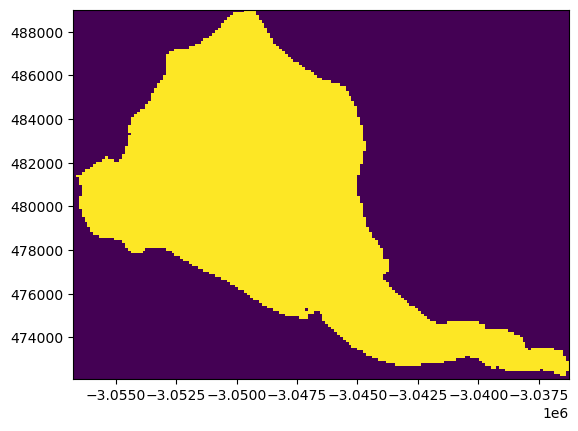

In [ ]:
plt.pcolormesh(X_arr[X_MIN:X_MAX], Y_arr[Y_MIN:Y_MAX], template)

### Calculate a inversion timeframe that fits all the datacubes

In [ ]:
min_date = []
max_date = []

for url in range(len(urls)):
    if mission:
        # Get the indices of the mission
        filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
        filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
        inds_mission = np.intersect1d(filt1[0],filt2[0])

        # Grab only the indices corresponding to the missions
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
    else:
        # If 'None' was passed as a mission argument, we grab all the available data.
        inds_mission = None
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
    
    # Get some arrays
    index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
    mid_dates = mid_dates[index_sort]
    im1 = im1[index_sort]
    im2 = im2[index_sort]

    # If sdate is later than the first available date, we find its corresponding index
    try:
        sdate_ind = np.where(mid_dates >= sdate)[0][0]
    except:
        sdate_ind = 0
    
    # If edate is sooner than the last available date, we find its corresponding index
    try:
        edate_ind = np.where(mid_dates > edate)[0][0]
    except:
        edate_ind = None
    
    # Create a False/True mask where True if the date is in the desired range
    mask_dates = np.full(mid_dates.shape, False)
    mask_dates[sdate_ind:edate_ind] = True

    # Keep only the values within the desired range
    mid_dates = mid_dates[mask_dates]
    im1 = im1[mask_dates]
    im2 = im2[mask_dates]

    # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
    if im2[0] < im1[0]:
        temp = im1
        im1 = im2
        im2 = temp

    min_date.append(im1[0])
    max_date.append(im2[-1])

# Determine the min and max of the dates available in the datacubes
min_date = np.min(min_date)
max_date = np.max(max_date)

In [ ]:
# Distance between two cell centers
space_interval = np.sqrt((X_arr[1]-X_arr[0])**2 + (Y_arr[1]-Y_arr[0])**2)

reg_mat_space, reg_mat_time, dates_nonum, dates, data_dict = design_matrices(urls, min_date, max_date, mission, lamb, derivative, day_interval, space_interval, sdate, edate, nb_pts_tot)

### Function to loop through every valid on-glacier pixel.

The following function calls the point's timeseries from ITS_LIVE, assembles the design matrix, and calls the inversion function. Once it is done, it stores the inversion output in the host matrices (vx & vy). It saves a copy of the matrices as a netcdf object every 10k iterations, and creates a text file printing how many iterations have been computed, every 100 iterations.

In [ ]:
def looper(i, GPU, spatial_regularization, nb_pts_tot, time_reg_mat, space_reg_mat, len_pt_inverted):
    
    global vxInv
    global vyInv
    
    # Get all the points used in the inversion. 1st point is the one we are inverting for
    vxObs = [np.array(data_dict[urls[P[i][v][2]]]['zarr_store']['vx'][:,  neighbor_idx[:,P[i][v][3]][0], neighbor_idx[:,P[i][v][3]][1]][data_dict[urls[P[i][v][2]]]['index_sort']][data_dict[urls[P[i][v][2]]]['mask_dates']], dtype=np.float64) for v in range(len(P[i]))]
    vyObs = [np.array(data_dict[urls[P[i][v][2]]]['zarr_store']['vy'][:,  neighbor_idx[:,P[i][v][3]][0], neighbor_idx[:,P[i][v][3]][1]][data_dict[urls[P[i][v][2]]]['index_sort']][data_dict[urls[P[i][v][2]]]['mask_dates']], dtype=np.float64) for v in range(len(P[i]))]
    
    # Grab the nodata value
    fillvalue = vxObs[0].min()
    
    # Mask the non-valid values
    mask = [np.logical_not(np.equal(vxObs[v], fillvalue)) for v in range(len(vxObs))]

    # Mask the observed vectors
    vxObs_masked = [vxObs[v][mask[v]] for v in range(len(vxObs))]
    vyObs_masked = [vyObs[v][mask[v]] for v in range(len(vyObs))]

    # Get the length of each point
    len_pts_tot =  [len(vxObs_masked[v]) for v in range(len(vxObs))]

    # Stack the observed vectors
    vxObs_masked = np.hstack(vxObs_masked)
    vyObs_masked = np.hstack(vyObs_masked)

    # Count the amount of points
    nb_pts = len(P[i])

    # Assemble the design matrix, masked 
    # Initialize the design matrix
    if spatial_regularization:
        A_des = np.zeros((len(vxObs_masked) + SRT[0] + SRS[0], SRT[1]))
        # Fill-in the values of A_m depending on each point
        cr = 0
        cc = 0
        for v in range(nb_pts):
            A_des[cr:cr+len_pts_tot[v], cc:cc+len_pt_inverted] = data_dict[urls[P[i][v][2]]]['A_m'][mask[v]]
            cr += len_pts_tot[v]
            cc += len_pt_inverted

        # Append time and spatial regularization matrices, fitted to the amount of points we have
        A_des[cr:cr + SRT[0], :] = time_reg_mat
        A_des[cr + SRT[0]:, :] = space_reg_mat

    else:
        A_des = np.zeros((len(vxObs_masked) + SRT[0], SRT[1]))
        cr = len_pts_tot[0]
        cc = len_pt_inverted
        A_des[:cr] = data_dict[urls[P[i][0][2]]]['A_m'][mask[0]]
        A_des[cr:cr + SRT[0], :] = time_reg_mat


    # Invert the velocities
    vxInv[: , y_matches[i], x_matches[i]] = Inverter(GPU, spatial_regularization, vxObs_masked, nb_pts, len_pt_inverted, A_des, device)
    vyInv[: , y_matches[i], x_matches[i]] = Inverter(GPU, spatial_regularization, vyObs_masked, nb_pts, len_pt_inverted, A_des, device)
    
    
    # Save the amount of iterations in a text file
    if i%100 == 0:
        with open("Counter.txt", "w") as text_file:
            text_file.write(f"Counter: {i}")

    # Save the matrices along-the-way in case the algorithm fails
    if i%10000 == 0 and i != 0:

        print(f"Saved at {i}")
        
        # Get the names of all the glaciers in the datacube 
        new_ds = xr.Dataset(
            {
                "vx": (["time", "y", "x"], vxInv.cpu().numpy()),
                "vy": (["time", "y", "x"], vyInv.cpu().numpy())
            },
            coords={
                "time": ind_tot,
                "x": X_arr[X_MIN:X_MAX],
                "y": Y_arr[Y_MIN:Y_MAX]
            },
            attrs=data_dict[urls[0]]['zarr_store'].attrs,
        ).chunk({'time': 1, 'x': 100, 'y': 100})

        from dask.diagnostics import ProgressBar
        write_job = new_ds.to_netcdf(f'Cube.nc', compute=False)
        with ProgressBar():
            print(f"Writing to {'Cube.nc'}")
            write_job.compute()
            

#### Inversion function

The function determines if we use GPU acceleration or not, and finds the optimal solution for a point.

In [ ]:
def Inverter(GPU, spatial_regularization, vObs_masked, nb_pts, len_pt_inverted, A_des, device):

    # Extend the observations with 0s to match the length of spacetime regularizations
    if spatial_regularization:
        vObs_masked = np.hstack((vObs_masked, np.zeros((SRT[0] + SRS[0]))))
    else:
        vObs_masked = np.hstack((vObs_masked, np.zeros((SRT[0]))))

    if GPU:
        # Migrate velocity vector to torch
        vObs_masked = torch.from_numpy(vObs_masked).to(device).double()
        # Migrate design matrix to GPU
        A_des = torch.from_numpy(A_des).to(device)
        vInv = torch.linalg.solve(A_des.T@A_des,A_des.T@(vObs_masked))[:len_pt_inverted].cpu()
    else:
        vInv = np.linalg.solve(A_des.T@A_des,A_des.T@(vObs_masked))[:len_pt_inverted]

    return vInv

#### Design Matrix components

Build the last bricks of the design matrix depending on how many points we use in the regularization & initialize host arrays for the inversion outputs



In [ ]:
SRT = reg_mat_time.shape
time_reg_mat = np.zeros((nb_pts_tot*SRT[0], nb_pts_tot*SRT[1]))


# Stack time_reg_temp on the diagonal of time_reg
for i in range(0,nb_pts_tot):
    time_reg_mat[i*SRT[0]:(i+1)*SRT[0], i*SRT[1]:(i+1)*SRT[1]] = reg_mat_time

if spatial_regularization:
    # Initialize spatial regulization matrix
    space_reg_mat = np.zeros((2*SRT[0], time_reg_mat.shape[1]))
    
    space_reg_mat[:, :SRT[1]] = np.tile(reg_mat_space[0], (2,1))
    space_reg_mat[:SRT[1], SRT[1]:3*SRT[1]] = np.tile(reg_mat_space[0], 2)
    space_reg_mat[SRT[1]:2*SRT[0], 3*SRT[1]:] = np.tile(reg_mat_space[0], 2)
    SRS = space_reg_mat.shape
else: 
    space_reg_mat = None
    
# Get the shapes of the regularization matrices
SRT = time_reg_mat.shape

# Initialize velocity matrices
len_pt_inverted = len(dates)
vxInv = np.full((len_pt_inverted, template.shape[0], template.shape[1]), np.nan)
vyInv = np.full((vxInv.shape), np.nan)


# Run the inversion

If GPU then we import the necessary package and variable
At the end, store as a netcdf

In [ ]:

if GPU:     
    import torch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = None

# Run the inversions for vx and vy and populate vxInv, vyInv
for i in tqdm(range(len(y_matches))):

    looper(i, GPU, spatial_regularization, nb_pts_tot, time_reg_mat, space_reg_mat, len_pt_inverted)    

 


    



  0%|          | 38/8962 [00:10<40:57,  3.63it/s] 


KeyboardInterrupt: 

### Quick data visualization


We then plot the average of each 2D (spatial) slice to give an idea of the glacier's velocity

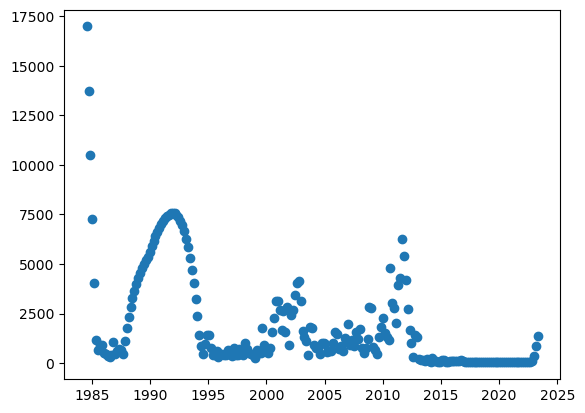

In [ ]:
# Calculate velocity magnitude
mag = np.sqrt(vxInv**2+vyInv**2)

# Plot the average velocity magnitude in time
plt.scatter(dates_nonum, np.nanmean(np.nanmean(mag, axis = 2), axis = 1))

### Filter the data

**Choose a threshold to throw away velocities that are above it**

We calculate the average velocity magnitude for each spatial cell of the glacier. If a timestamp leads to X times the average velocity magnitude at that point, we throw it out.

In [ ]:
X = 10  # If a velocity is 10 times above the threshold, we take it out

In [ ]:
# Grab the indices where the velocity is above X times the mean
mask_mag = np.logical_not(mag <= X*np.nanmean(mag, axis = 0))

### Mask the velocities above the threshold

In [ ]:
vxInv[mask_mag] = np.nan
vyInv[mask_mag] = np.nan
mag[mask_mag] = np.nan

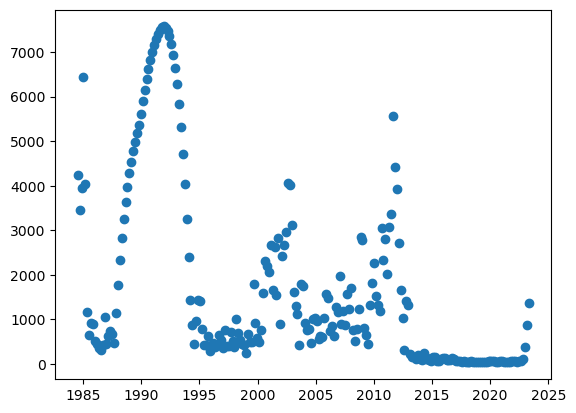

In [ ]:
# Replot the average velocity magnitude now that it has been filtered
plt.scatter(dates_nonum, np.nanmean(np.nanmean(mag, axis = 2), axis = 1))

### Export the variables

We save everything as a netcdf file, chunked with dask in order to avoid RAM overflow.

In [ ]:
# Save the dataset
new_ds = xr.Dataset(
{
    "vx": (["time", "y", "x"], vxInv),
    "vy": (["time", "y", "x"], vyInv),
    "mask": (["time", "y", "x"], mask_mag),
},
coords={
    "time": ind_tot,
    "x": X_arr[X_MIN:X_MAX],
    "y": Y_arr[Y_MIN:Y_MAX]
},
attrs=data_dict[urls[0]]['zarr_store'].attrs,
).chunk({'time': 1, 'x': 100, 'y': 100})

from dask.diagnostics import ProgressBar
write_job = new_ds.to_netcdf(f'Cube.nc', compute=False)
with ProgressBar():
    print(f"Writing to {'Cube.nc'}")
    write_job.compute()   
